# Group 5: Synthetic Signal Analysis

Goal: to obtain a clear estimation of each components by working only with the final signal

* Analyse the final signal: stationary or non-stationary

* Run a FFT analysis to get an idea of the frequency components. Reflect on the results of this analysis

* How to decide the window size if STFT or WT is going to be used?

* Which signal processing technique is best for your signal (FFT, STFT, WVT, WT, HT)? 

* Add an offset and repeat the analysis

* Add white noise and repeat the analysis

* Add a linearly time varying frequency component (frequency=kt)

* Add an offset and white noise and repeat the analysis

Our signal: Components: 5, 48 abd 50 Hz


In [2]:
%matplotlib notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

## A)

<IPython.core.display.Javascript object>


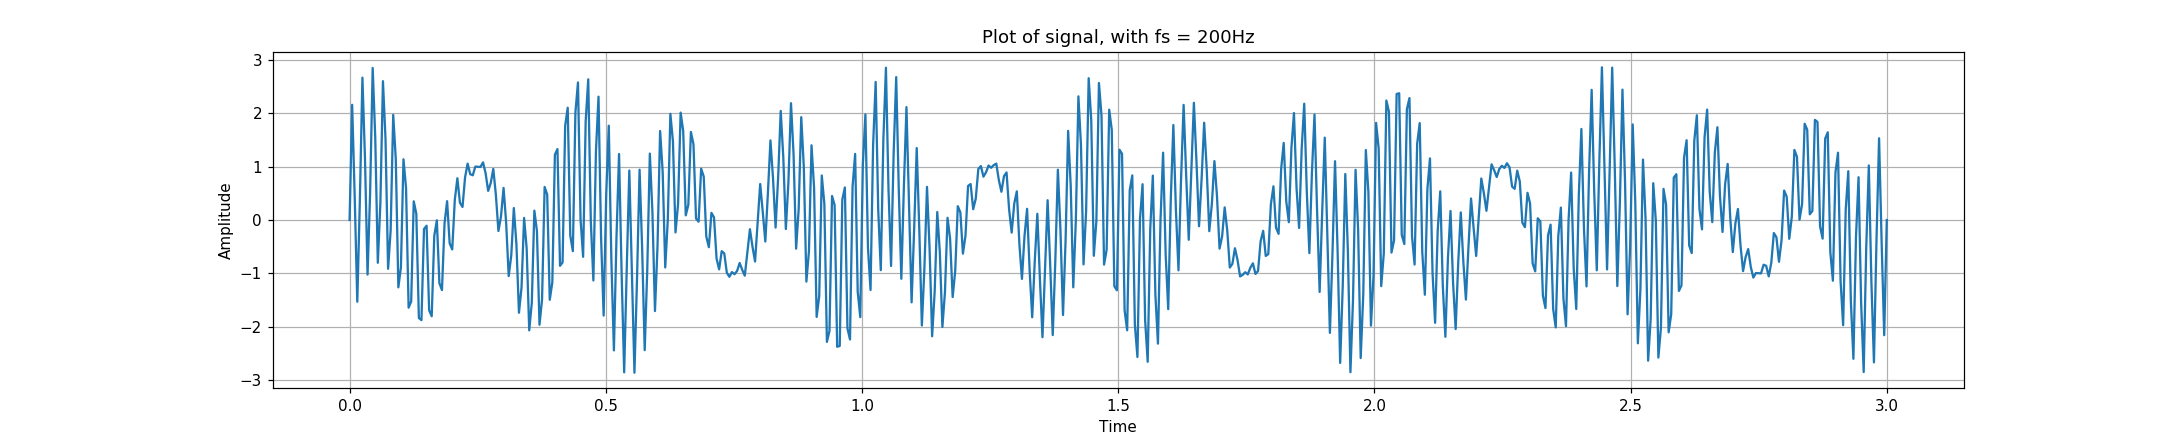

In [4]:
'''
Since the maximum frequency in our signal is 50Hz, then the sampeling 
frequency needs to be bigger than 2*50Hz => over 100Hz
'''
T0 = 3
fs = 200.0
T = 1.0/fs
N = int(T0 / T)



x = np.linspace(0.0, N*T, N)

y = np.sin(5.0 * 2.0*np.pi*x) + np.sin(48.0 * 2.0*np.pi*x)+ np.sin(50.0 * 2.0*np.pi*x)

plt.figure(figsize=(20, 4))
plt.plot(x, y)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Plot of signal, with fs = 200Hz')
plt.grid()
plt.draw()

The signal above is stationary, because the frequency components are constant / does not change with time

## B)

<IPython.core.display.Javascript object>


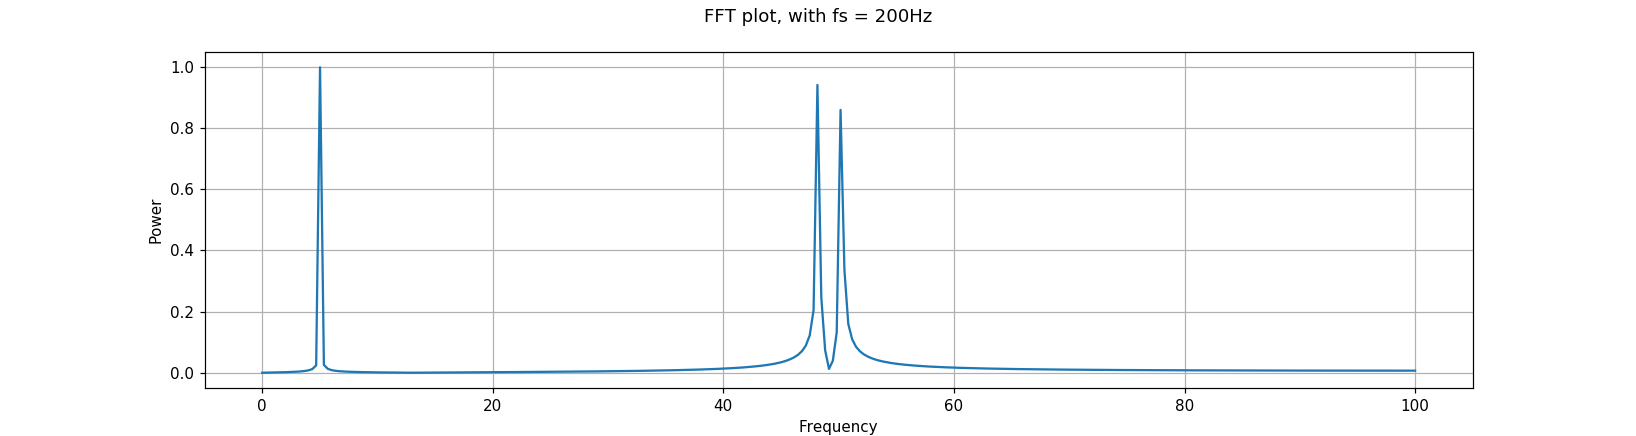

In [5]:
from scipy.fft import fft

yf = fft(y)

xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(15, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.ylabel('Power')
plt.xlabel('Frequency')
plt.suptitle('FFT plot, with fs = 200Hz')
plt.show()

We have three prominent peaks at three frequencies 5, 48, 50 Hz. It looks like the signal does not contain any noise, due to the absence of jittering in the PSD-plot. 

>"A proper trade-off between time- and frequency resolution
is found by choosing the length of the window about the
same size as the time-invariance or stationarity of the
individual signal components. "


Uncertainty principle
$$ \Delta \omega * \Delta t \geq \frac{1}{2} $$ 

Since we "know" that the maximum frequency is 50Hz, which gives a minimum period of 1/50Hz, we want to fit one period into one window. The window sice should hence be maximum 1/50. 
In practice, when working with non-stationary signals, it can be informative to look at the signal, and identify time-slots where the signal is nearly stationary, and use this window size for the analysis. 


In [6]:
window = 1/50
print(f'The window length needs to be at least {round(window,4)} seconds')
nseg = T0 / window
print(f'The number of segments to be used {int(nseg)}')


The window length needs to be at least 0.02 seconds
The number of segments to be used 150


## C)

#### using STFT

<IPython.core.display.Javascript object>


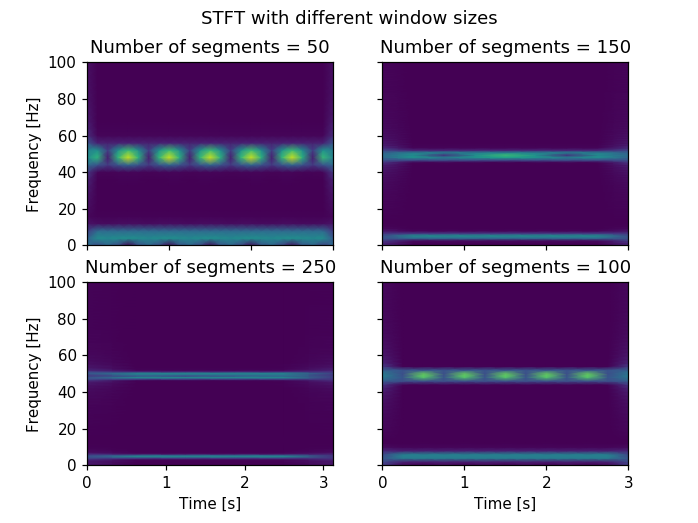

Text(0.5, 0.98, 'STFT with different window sizes')

In [8]:
from scipy.signal import stft
res = []
for i in range(3):
    f, t, Zxx = stft(y, fs, nperseg=nseg + (i - 1)* 100)
    res.append([f, t, Zxx])
    
f, t, Zxx = stft(y, fs, nperseg=100)
res.append([f, t, Zxx])


fig, axs = plt.subplots(2, 2)

axs[0, 0].pcolormesh(res[0][1], res[0][0], np.abs(res[0][2]), vmin=0, vmax=1, shading='gouraud')
axs[0, 0].set_title('Number of segments = 50')
axs[0, 1].pcolormesh(res[1][1], res[1][0], np.abs(res[1][2]), vmin=0, vmax=1, shading='gouraud')
axs[0, 1].set_title('Number of segments = 150')
axs[1, 0].pcolormesh(res[2][1], res[2][0], np.abs(res[2][2]), vmin=0, vmax=1, shading='gouraud')
axs[1, 0].set_title('Number of segments = 250')
axs[1, 1].pcolormesh(res[3][1], res[3][0], np.abs(res[3][2]), vmin=0, vmax=1, shading='gouraud')
axs[1, 1].set_title('Number of segments = 100')

for ax in axs.flat:
    ax.set(xlabel='Time [s]', ylabel='Frequency [Hz]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.suptitle('STFT with different window sizes')

#### Using WVD (Wigner-Ville Distribution)

https://tftb.readthedocs.io/en/latest/auto_examples/plot_4_1_3_chirps_wvd.html

> The WVD does not suffer from leakage effects as the STFT does. Hence, the WVD gives you the best spectral resolution.
However, if you have signals with several frequency components, the WVD suffers from the so called cross terms.

Since we have a stationary multicomponent signal Wigner-Ville fails to tell us something about each individual frequency. If the signal was an impulse, then this plot would give greater insight to the power of the signal in time. 

<IPython.core.display.Javascript object>


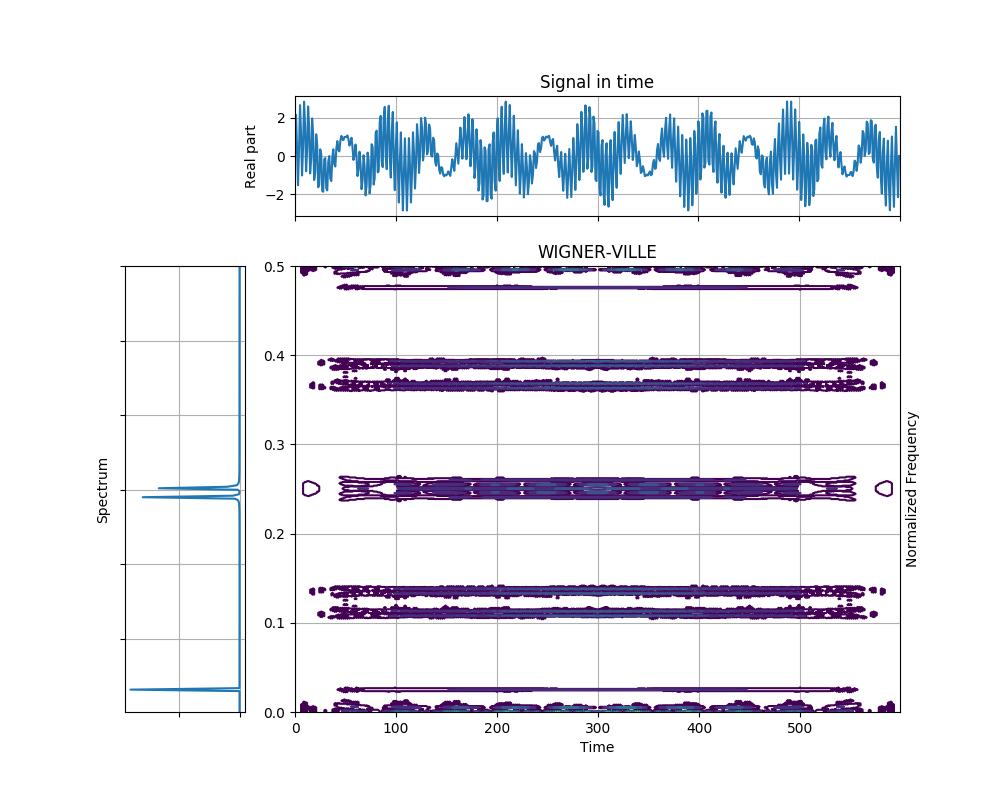

In [19]:
from tftb.generators import fmlin, amgauss
from tftb.processing import WignerVilleDistribution


tfr = WignerVilleDistribution(y)
tfr.run()
tfr.plot(show_tf=True,  kind='contour')

#### Using WT (Wavelet Transform)

Is suitable for analysing irregular data patterns, such as non-stationary signals. As we can see below, the scaleogram shows that the wavelet transform is able to extract periodic intensities which coincides with our signal. However, it fails to extract the correct frequency components as it will average the frequencies it recovers over the whole time range.

<IPython.core.display.Javascript object>


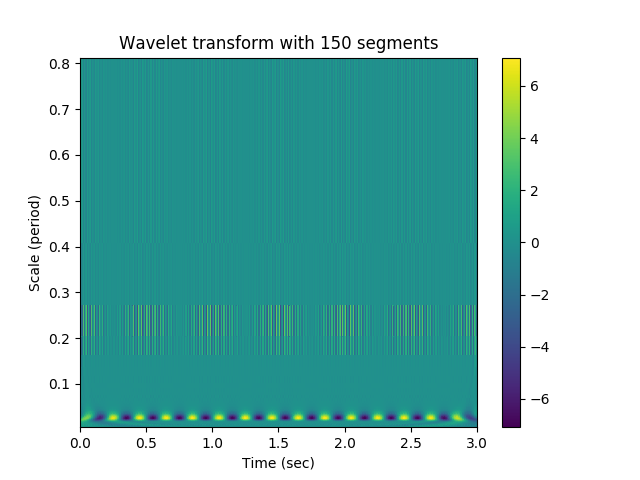

In [21]:
import pywt

plt.figure()
# scales = np.arange(1, 51)
scales = np.arange(1, nseg)
cwtmatr, freqs = pywt.cwt(y, scales, 'morl')
plt.pcolor(x, freqs, cwtmatr)

# plt.ylim([1, 100])
plt.ylabel('Scale (period)')
plt.xlabel('Time (sec)')
plt.title('Wavelet transform with 150 segments')
plt.colorbar()

#### Hilbert Transform

Used on MONO-signals. In our case we have multiple frequencies in the signal, hence HT will not work, unless we transform the signal into one frequency component. 

<IPython.core.display.Javascript object>


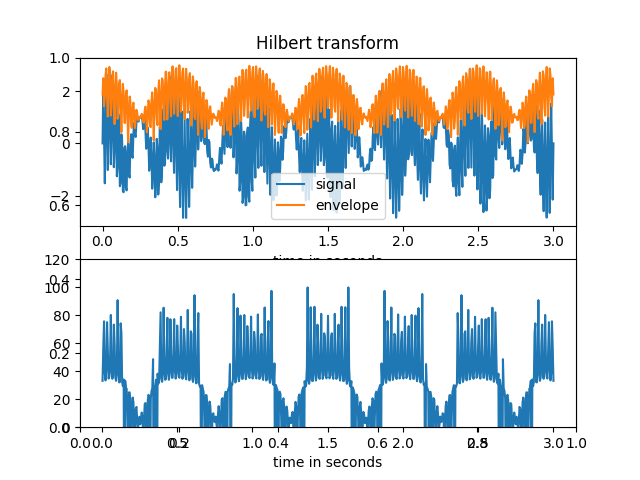

(0.0, 120.0)

In [23]:
from scipy.signal import hilbert

analytic_signal = hilbert(y)

amplitude_envelope = np.abs(analytic_signal)

instantaneous_phase = np.unwrap(np.angle(analytic_signal))

instantaneous_frequency = (np.diff(instantaneous_phase) /

                           (2.0*np.pi) * fs)

fig = plt.figure()

plt.title('Hilbert transform')
ax0 = fig.add_subplot(211)

ax0.plot(x, y, label='signal')

ax0.plot(x, amplitude_envelope, label='envelope')

ax0.set_xlabel("time in seconds")

ax0.legend()

ax1 = fig.add_subplot(212)

ax1.plot(x[1:], instantaneous_frequency)

ax1.set_xlabel("time in seconds")

ax1.set_ylim(0.0, 120.0)